# Zillow Project

In [6]:
import pandas as pd 
import numpy as np 
import seaborn as sns
from scipy import stats
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression
from math import sqrt
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

import env
import acquire
import features
import evaluate

## Acquistion

In [5]:
df = acquire.wrangle_zillow()

## Explore

In [8]:
df.shape

(14892, 8)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14892 entries, 0 to 14892
Data columns (total 8 columns):
bedroom_count     14892 non-null float64
bathroom_count    14892 non-null float64
square_feet       14892 non-null float64
property_value    14892 non-null float64
tax_paid          14892 non-null float64
tax_rate          14892 non-null float64
property_type     14892 non-null object
county_code       14892 non-null float64
dtypes: float64(7), object(1)
memory usage: 1.0+ MB


In [11]:
df.describe()

,bedroom_count,bathroom_count,square_feet,property_value,tax_paid,tax_rate,county_code
count,14892.000000,14892.000000,14892.000000,1.489200e+04,14892.000000,14892.000000,14892.000000
mean,3.316143,2.324302,1938.497045,5.396460e+05,6564.370992,1.339895,6049.448429
std,0.926831,1.014254,992.488089,7.290735e+05,8428.010576,0.678182,21.272489
min,1.000000,1.000000,300.000000,1.050400e+04,51.260000,0.078687,6037.000000
25%,3.000000,2.000000,1276.000000,1.991870e+05,2710.622500,1.159710,6037.000000
50%,3.000000,2.000000,1678.000000,3.847785e+05,4762.040000,1.230339,6037.000000
75%,4.000000,3.000000,2342.250000,6.435572e+05,7637.557500,1.368188,6059.000000
max,11.000000,11.000000,15450.000000,2.385837e+07,276797.830000,45.288365,6111.000000


## Distribution of tax rates by county

- Identify the counties in the data and analyze the tax values

In [14]:
# Create column with county name instead of relying on county code.

df['county_name'] = df['county_code'].map({6037: "Los_Angeles_County", 6059: "Orange_County", 6111: "Ventura_County"})
df.head(1)

,bedroom_count,bathroom_count,square_feet,property_value,tax_paid,tax_rate,property_type,county_code,county_name
0,3.0,2.0,1458.0,136104.0,2319.9,1.704505,Single Family Residential,6037.0,Los_Angeles_County


In [17]:
# Create a dataframe that contains vital county tax information

df_county_tax = df[['county_code', 'county_name', 'tax_rate']]

In [18]:
df_county_tax.head(5)

,county_code,county_name,tax_rate
0,6037.0,Los_Angeles_County,1.704505
1,6037.0,Los_Angeles_County,1.526962
2,6037.0,Los_Angeles_County,1.249705
3,6037.0,Los_Angeles_County,1.191477
4,6037.0,Los_Angeles_County,1.230421


In [23]:
los_angles_tax = df_county_tax.tax_rate[df_county_tax.county_name == 'Los_Angles_County']

In [28]:
orange_county = df.tax_rate[df.county_name == 'Orange_County']


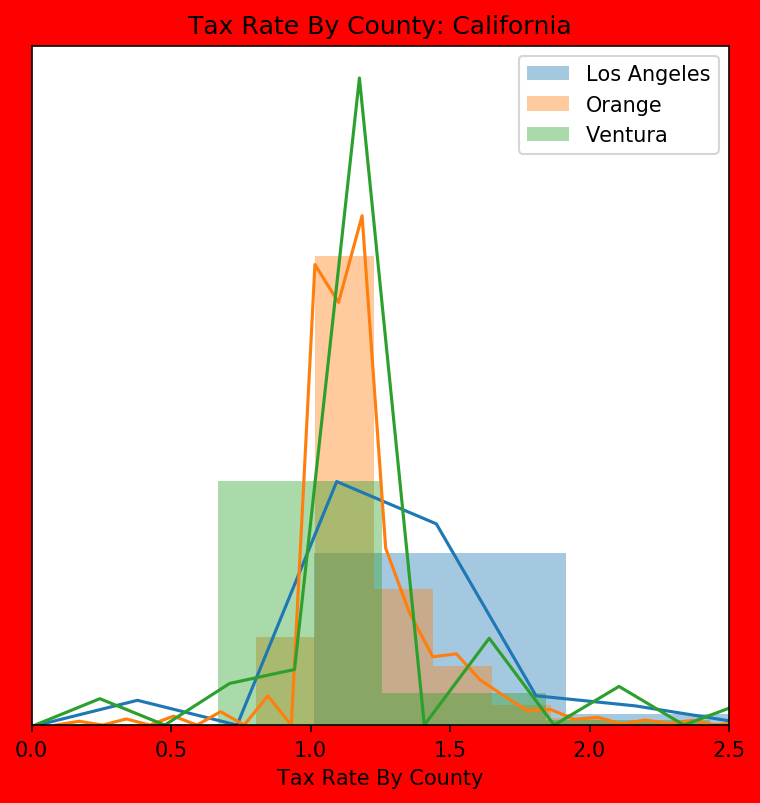

In [32]:
la_county = df_county_tax[df_county_tax.county_name == "Los_Angeles_County"].tax_rate
orange_county = df_county_tax[df_county_tax.county_name == 'Orange_County'].tax_rate
ventura_county = df_county_tax[df_county_tax.county_name == 'Ventura_County'].tax_rate

# len(la_county)
# len(orange_county)
# len(ventura_county)
plt.figure(figsize = (6,6), dpi = 150, facecolor = "r")
sns.distplot(la_county, label = "Los Angeles")
sns.distplot(orange_county, label = "Orange")
sns.distplot(ventura_county, label = "Ventura")
plt.xlim(0, 2.5)
plt.legend()
plt.yticks([])
plt.title("Tax Rate By County: California")
plt.xlabel('Tax Rate By County')
plt.show()